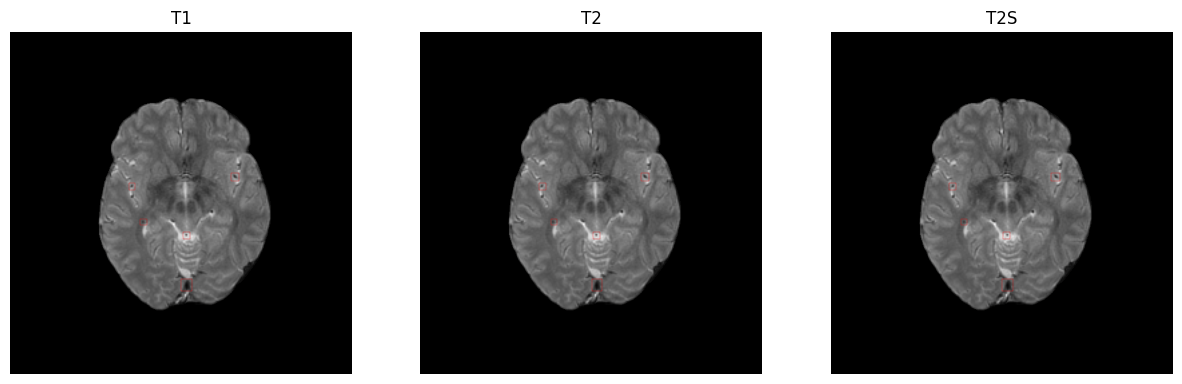

In [7]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the YOLO output
yolo_output = [
    {"image_id": "sub-321_slice_018", "category_id": 1, "bbox": [1324.364, 846.783, 45.836, 42.18], "score": 0.30959}, {"image_id": "sub-321_slice_018", "category_id": 1, "bbox": [781.628, 1121.846, 34.416, 32.095], "score": 0.20253}, {"image_id": "sub-321_slice_018", "category_id": 1, "bbox": [1037.049, 1200.941, 36.505, 34.332], "score": 0.05122}, {"image_id": "sub-321_slice_018", "category_id": 1, "bbox": [711.429, 906.143, 36.348, 35.279], "score": 0.01537}, {"image_id": "sub-321_slice_018", "category_id": 1, "bbox": [1028.188, 1478.755, 60.521, 66.992], "score": 0.01212}
]

# Root path of the images
root_path =  "/mnt/storage/ji/brain_mri_valdo_mayo/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s_GAN_cmbTrainOnly/images/val"


# Function to visualize the image with bounding boxes on separate channels
def visualize_image_with_bboxes(image_id, bboxes):
    image_path = os.path.join(root_path, f"{image_id}.png")
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # Separate the channels
    red_channel = image_array[:, :]
    green_channel = image_array[:, :]
    blue_channel = image_array[:, :]

    # Plot the channels with bounding boxes
    plt.figure(figsize=(15, 5))

    for i, (channel, cmap, title) in enumerate(zip([red_channel, green_channel, blue_channel], ['Reds', 'Greens', 'Blues'], ['T1', 'T2', 'T2S'])):
        plt.subplot(1, 3, i + 1)
        plt.imshow(channel, cmap='gray')
        for bbox in bboxes:
            x, y, width, height = bbox
            # Increase the size of the bounding box
            rect = plt.Rectangle((x - 2, y - 2), width + 4, height + 4, edgecolor='red', facecolor='none', linewidth=0.2)
            plt.gca().add_patch(rect)
        plt.title(title)
        plt.axis('off')

    plt.show()

# Group bounding boxes by image_id
bboxes_by_image = {}
for item in yolo_output:
    image_id = item['image_id']
    bbox = item['bbox']
    if image_id not in bboxes_by_image:
        bboxes_by_image[image_id] = []
    bboxes_by_image[image_id].append(bbox)

# Visualize each image with its bounding boxes on separate channels
for image_id, bboxes in bboxes_by_image.items():
    visualize_image_with_bboxes(image_id, bboxes)

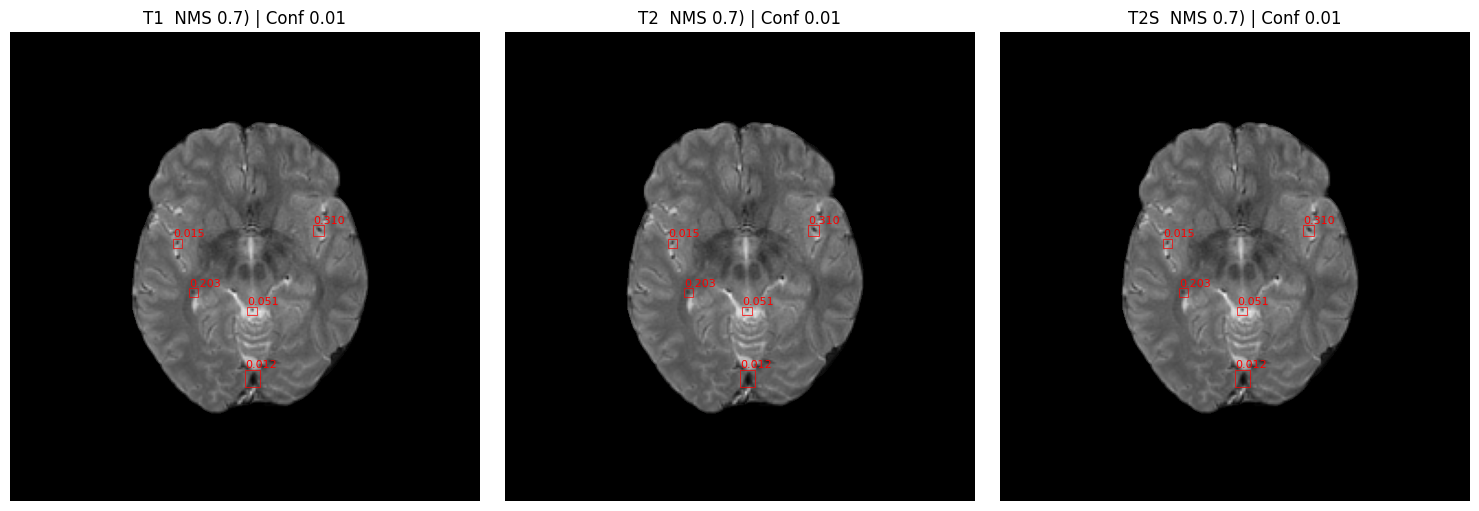

In [8]:
# Function to calculate IoU between two bounding boxes
def calculate_iou(box1, box2):
    # Extract coordinates
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

# Function to apply NMS
def apply_nms(predictions, iou_threshold):
    if not predictions:
        return []
    
    # Sort by confidence score (high to low)
    sorted_preds = sorted(predictions, key=lambda x: x['score'], reverse=True)
    selected = []
    
    while sorted_preds:
        current = sorted_preds.pop(0)
        selected.append(current)
        
        # Filter out boxes with high IoU
        remaining = []
        for pred in sorted_preds:
            iou = calculate_iou(current['bbox'], pred['bbox'])
            if iou <= iou_threshold:
                remaining.append(pred)
        sorted_preds = remaining
    
    return selected

# Function to visualize the image with bounding boxes and scores on separate channels
def visualize_image_with_bboxes_and_scores(image_id, predictions, confidence_threshold=0.0, nms_threshold=None):
    """
    Visualize image with bounding boxes and their confidence scores.
    
    Args:
        image_id: The image identifier
        predictions: List of prediction dictionaries with bbox and score
        confidence_threshold: Minimum confidence score to display
        nms_threshold: IoU threshold for NMS (None to skip NMS)
    """
    image_path = os.path.join(root_path, f"{image_id}.png")
    
    # Filter predictions by confidence threshold
    filtered_preds = [p for p in predictions if p['score'] >= confidence_threshold]
    
    # Apply NMS if threshold is provided
    if nms_threshold is not None:
        filtered_preds = apply_nms(filtered_preds, nms_threshold)
        title_suffix = f"  NMS {nms_threshold}) | Conf {confidence_threshold}"
    else:
        title_suffix = ""
    
    try:
        # Load the image
        image = Image.open(image_path)
        image_array = np.array(image)
        
        # Separate the channels (assuming grayscale image, duplicating for visualization)
        red_channel = image_array[:, :]
        green_channel = image_array[:, :]
        blue_channel = image_array[:, :]
        
        # Plot the channels with bounding boxes and scores
        plt.figure(figsize=(15, 5))
        
        for i, (channel, cmap, title) in enumerate(zip([red_channel, green_channel, blue_channel], 
                                                     ['Reds', 'Greens', 'Blues'], 
                                                     ['T1', 'T2', 'T2S'])):
            plt.subplot(1, 3, i + 1)
            plt.imshow(channel, cmap='gray')
            
            for pred in filtered_preds:
                bbox = pred['bbox']
                score = pred['score']
                
                x, y, width, height = bbox
                
                # Use red color for all bounding boxes
                color = 'red'
                
                # Increase the size of the bounding box
                rect = plt.Rectangle((x - 2, y - 2), width + 4, height + 4, 
                                    edgecolor=color, facecolor='none', linewidth=0.5)
                plt.gca().add_patch(rect)
                
                # Add score text above the box (also in red)
                plt.text(x, y - 4, f"{score:.3f}", color=color, 
                        fontsize=8, ha='left', va='bottom')
            
            plt.title(f"{title}{title_suffix}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        # Create a blank visualization instead
        create_blank_visualization(image_id, filtered_preds)

# Function to create visualization on a blank canvas when image is not available
def create_blank_visualization(image_id, predictions, width=400, height=512):
    """Create visualization on a blank canvas when image is not available"""
    plt.figure(figsize=(10, 10))
    plt.title(f"Predictions for {image_id}")
    
    # Create a blank gray background
    plt.imshow(np.ones((height, width)) * 0.9, cmap='gray')
    
    # Add bboxes and scores
    for pred in predictions:
        bbox = pred['bbox']
        score = pred['score']
        
        x, y, width, height = bbox
        
        # Use red color for all bounding boxes
        color = 'red'
        
        rect = plt.Rectangle((x, y), width, height, 
                            edgecolor=color, facecolor='none', linewidth=1.0)
        plt.gca().add_patch(rect)
        
        # Add score text above the box (also in red)
        plt.text(x, y - 3, f"{score:.3f}", color=color, 
                fontsize=9, ha='left', va='bottom')
    
    plt.axis('off')
    plt.show()

# Group predictions by image_id
predictions_by_image = {}
for item in yolo_output:
    image_id = item['image_id']
    if image_id not in predictions_by_image:
        predictions_by_image[image_id] = []
    predictions_by_image[image_id].append(item)

# Visualize each image with its bounding boxes and scores
for image_id, predictions in predictions_by_image.items():
    # Without NMS
    # visualize_image_with_bboxes_and_scores(
    #     image_id, 
    #     predictions,
    #     confidence_threshold=0.01
    # )
    
    # With NMS threshold of 0.7
    visualize_image_with_bboxes_and_scores(
        image_id, 
        predictions,
        confidence_threshold=0.01,
        nms_threshold=0.7
    )

In [ ]:
def find_nonempty_text_files(directory):
    """
    Find all non-empty .txt files in a directory
    Returns a list of file names
    """
    nonempty_files = []
    dir_path = Path(directory)
    
    # Find all .txt files
    for txt_file in dir_path.glob("*.txt"):
        # Check if file is not empty
        if txt_file.stat().st_size > 0:
            with open(txt_file, 'r') as f:
                content = f.read().strip()
                if content:  # Check if there's actual content after stripping whitespace
                    nonempty_files.append(txt_file.name)
    
    return sorted(nonempty_files)  # Sort alphabetically

task = "val"
directory = '/mnt/storage/ji/brain_mri_valdo_mayo/valdo_resample_ALFA_YOLO_PNG/labels/val'
# directory = f"{root_path}/labels/{task}"  # Replace with your folder path
nonempty_files = find_nonempty_text_files(directory)

print(f"Found {len(nonempty_files)} non-empty text files:")
for filename in nonempty_files:
    print(f"- {filename}")